In [1]:
import os
import sys
while not os.getcwd().endswith('ml'):
    os.chdir('..')
sys.path.insert(0, os.getcwd())

In [2]:
import pandas as pd
import numpy as np
import copy

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, validation_curve

import xgboost as xgb

import matplotlib.pyplot as plt

from kaggle.walmart_recruiting_sales_in_stormy_weather import common

#### Считывание данных

In [3]:
key = pd.read_csv("kaggle/walmart_recruiting_sales_in_stormy_weather/key.csv")
train = pd.read_csv("kaggle/walmart_recruiting_sales_in_stormy_weather/train.csv")
test = pd.read_csv("kaggle/walmart_recruiting_sales_in_stormy_weather/test.csv")
weather = pd.read_csv("kaggle/walmart_recruiting_sales_in_stormy_weather/weather.csv")

#### Удаление товаров которые никогда не торговались

In [5]:
common.add_id_field(train)
common.add_id_field(test)

unclaimed_products = common.get_unclaimed_products(train)
unclaimed_ids_from_test = test[test['product'].isin(unclaimed_products)]['id']


#### Предобработка данных

In [9]:
weather = weather.replace('M', -1)
weather = weather.replace('  T', 0.001)

for c in set(weather.columns) - set(['date', 'codesum', 'sunrise', 'sunset']):
    weather[c] = pd.to_numeric(weather[c])
    
common.convert_to_minutes(weather['sunrise'])
common.convert_to_minutes(weather['sunset'])

mlb = MultiLabelBinarizer()
codesum_data = pd.DataFrame(mlb.fit_transform(weather['codesum'].str.split()),columns=mlb.classes_)
weather_codesum = weather.join(codesum_data.sort_index(axis=1))


preprocessed_train = common.preprocessing(train[~train['product'].isin(unclaimed_products)], key, weather_codesum)
preprocessed_test = common.preprocessing(test[~test['product'].isin(unclaimed_products)], key, weather_codesum)

train_columns = preprocessed_train.columns
test_columns = preprocessed_test.columns
diff_columns = list(set(train_columns) - set(test_columns))
diff_columns.remove(common.TARGET_NAME)
print("Diff of columns {}". format(diff_columns))
for column in diff_columns:
    preprocessed_test[column] = 0 # Add missing field after onehot encoding

Diff of columns []


#### Feature importance

In [10]:
persent = 0.1

y = preprocessed_train['units']
X = preprocessed_train.loc[:, preprocessed_train.columns != 'units']

samples = np.random.choice(X.shape[0], int(X.shape[0] * persent), replace=False)

X = X.iloc[samples]
y = y.iloc[samples]

model = RandomForestRegressor(criterion='mse', n_estimators=10, max_depth=30)
model.fit(X, y)

RandomForestRegressor(max_depth=30, n_estimators=10)

In [11]:
feature_importance, feature_name = zip(*sorted([ i for i in zip(model.feature_importances_, X.columns)]))

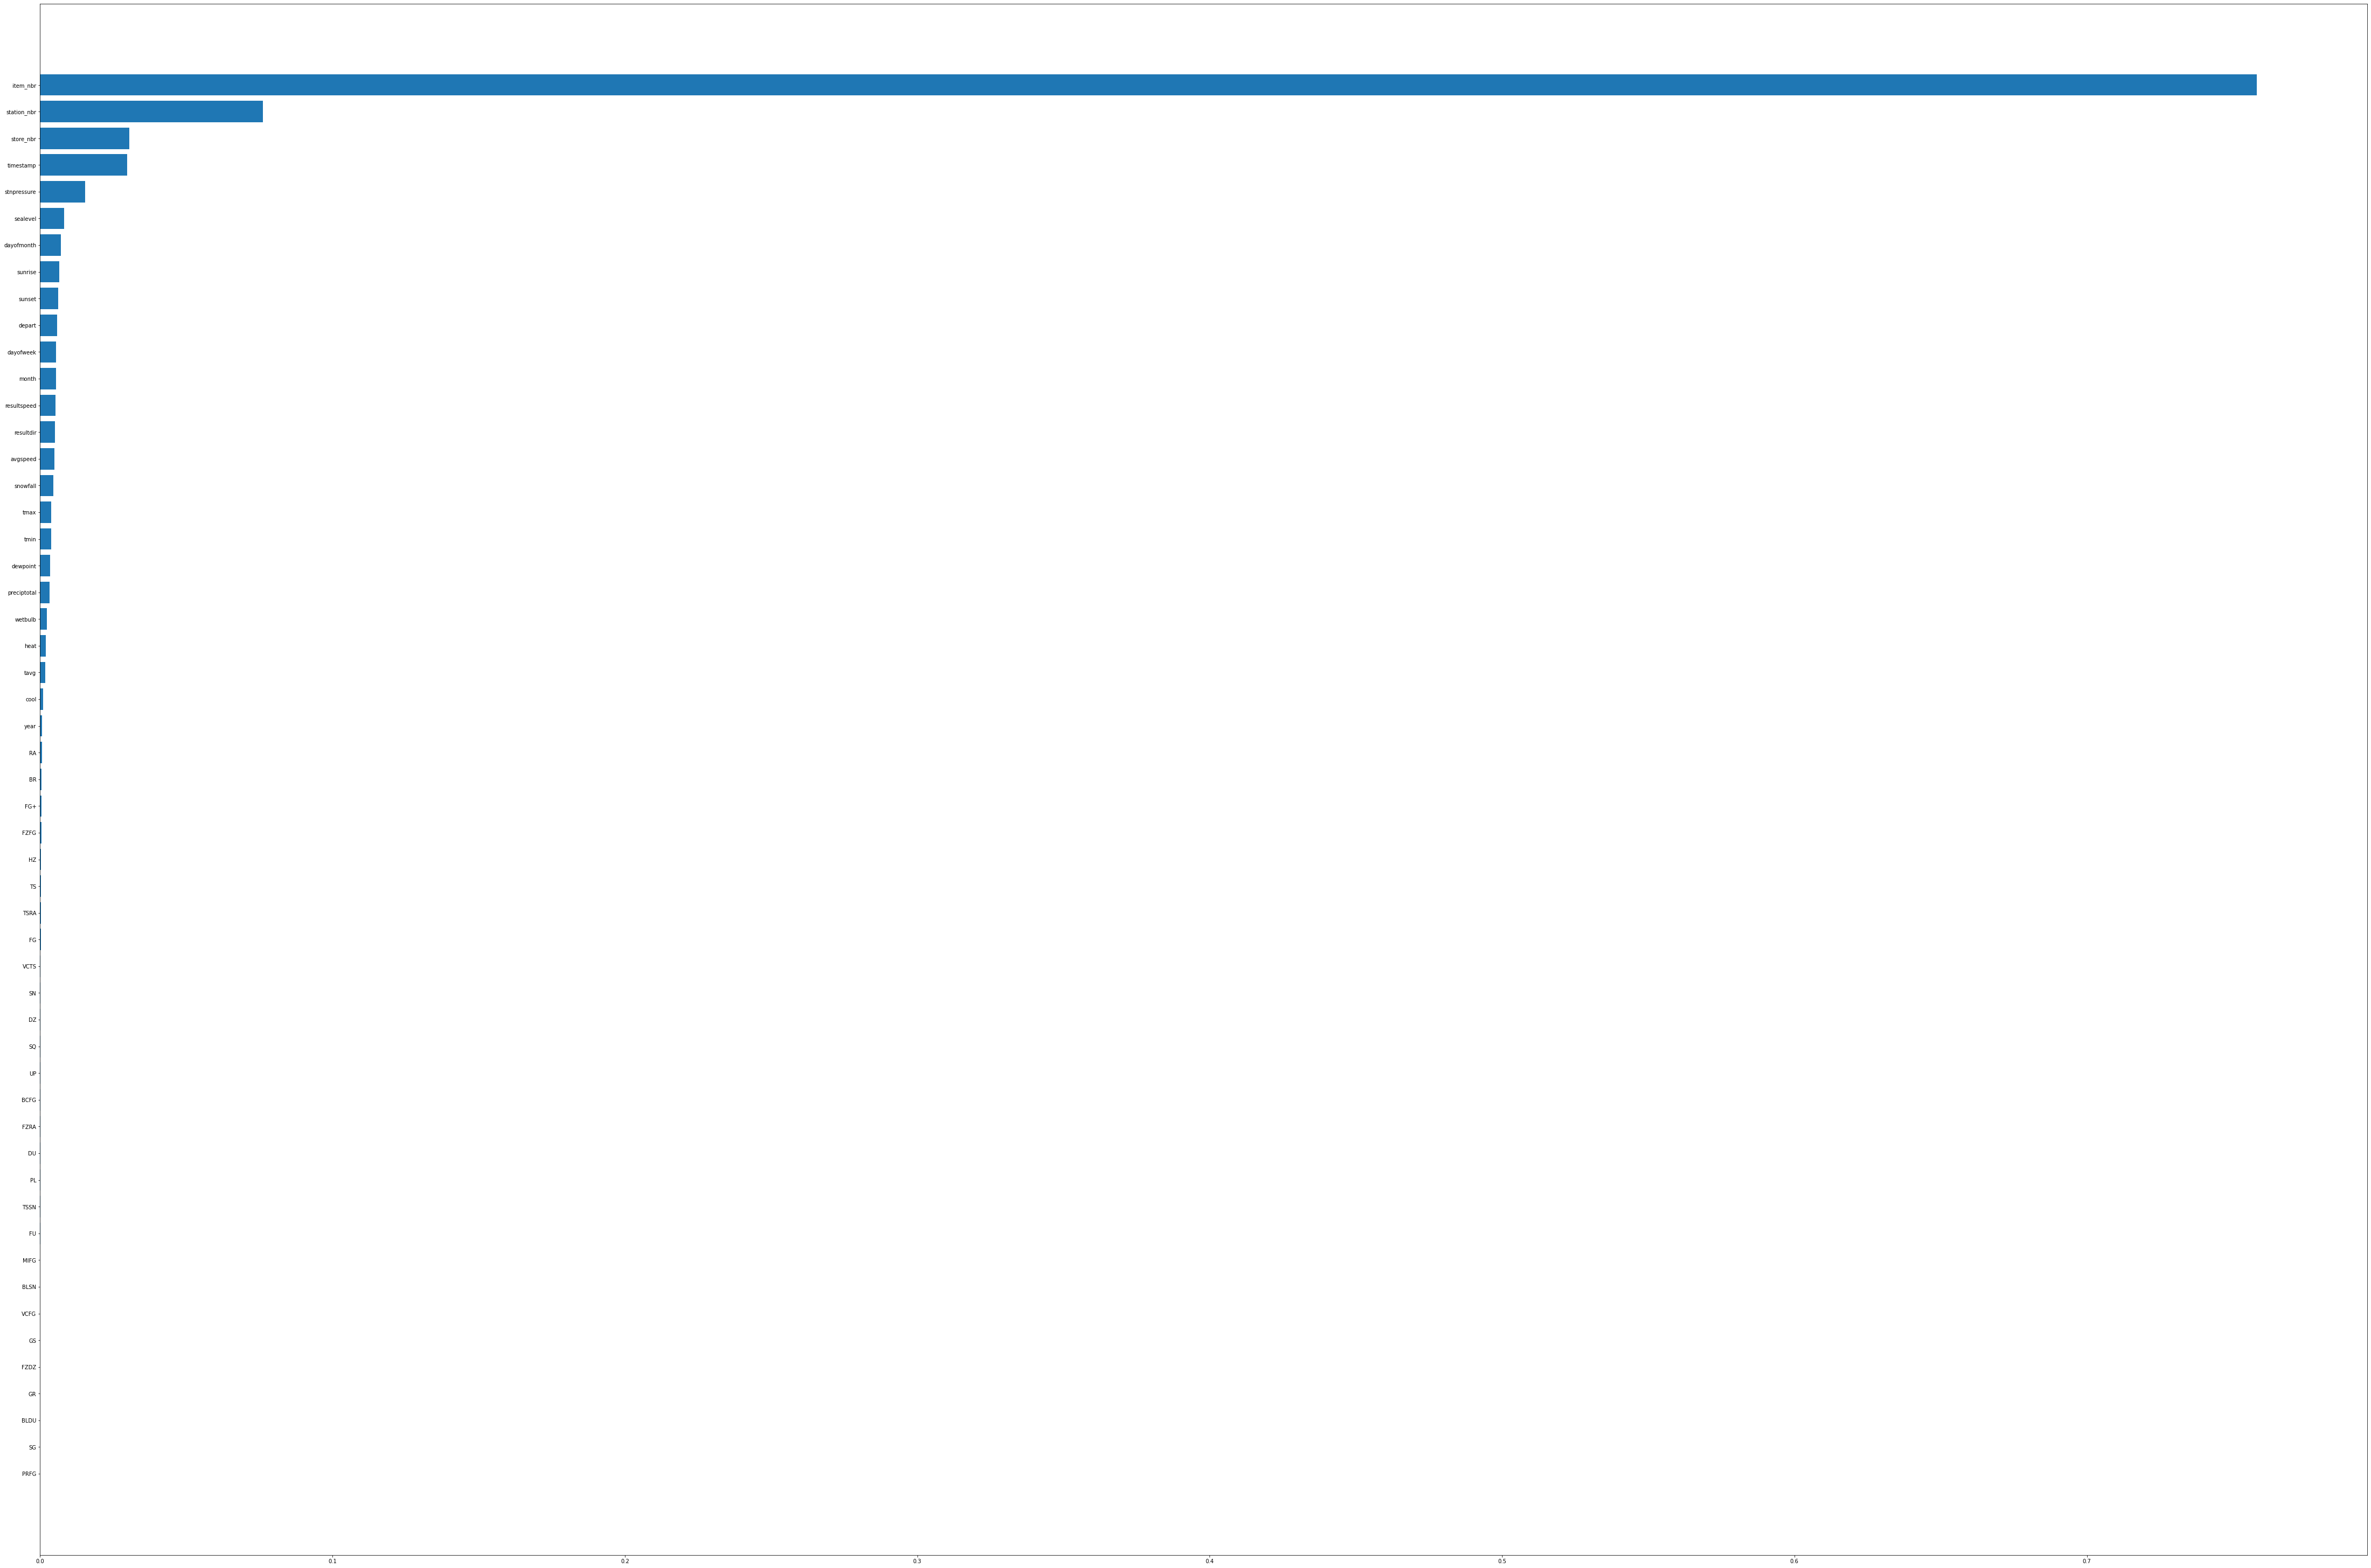

In [12]:
feature_importance, feature_name = zip(*sorted([ i for i in zip(model.feature_importances_, X.columns)]))

fig = plt.figure()
ax = fig.add_axes([0,0,10,10])

ax.barh(feature_name,feature_importance)
plt.show()

#### Валидационнная кривая

In [13]:
persent = 0.1

y = preprocessed_train['units']
X = preprocessed_train.loc[:, preprocessed_train.columns != 'units']

samples = np.random.choice(X.shape[0], int(X.shape[0] * persent), replace=False)

X = X.iloc[samples]
y = y.iloc[samples]

data = [10, 20, 30]

train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestRegressor(criterion='mse', max_depth=25, min_samples_split=5),
                                X = X, y = y, 
                                param_name = 'n_estimators', 
                                param_range = data, 
                                cv = 3,
                                scoring='neg_mean_squared_error')

train_scoreNum = -np.mean(train_scoreNum, axis=1)
test_scoreNum = -np.mean(test_scoreNum, axis=1)

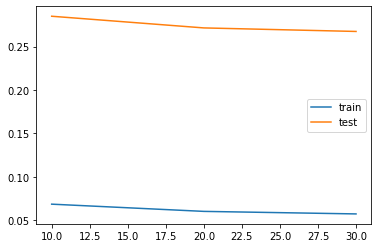

In [14]:
plt.plot(data, train_scoreNum)
plt.plot(data, test_scoreNum)
plt.legend(["train", "test"])
plt.show()

#### Кросвалидация

In [15]:
persent = 0.1

y = preprocessed_train['units']
X = preprocessed_train.loc[:, preprocessed_train.columns != 'units']

samples = np.random.choice(X.shape[0], int(X.shape[0] * persent), replace=False)

X = X.iloc[samples]
y = y.iloc[samples]


n_estimators = [100]
max_depth = [25]
min_samples_split = [5]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split)

model = RandomForestRegressor(criterion='mse')

gridF = GridSearchCV(model, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1,
                    scoring='neg_mean_squared_error')

bestF = gridF.fit(X, y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   45.4s finished


In [16]:
print(bestF.best_params_, bestF.best_score_)

{'max_depth': 25, 'min_samples_split': 5, 'n_estimators': 100} -0.2612963274561217


#### Обучение модели

In [15]:
y = preprocessed_train['units']
X = preprocessed_train.loc[:, preprocessed_train.columns != 'units']

In [16]:
model = RandomForestRegressor(criterion='mse', **bestF.best_params_)

In [17]:
model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### Предсказание

In [33]:
y_predict = model.predict(preprocessed_test)
y_predict = np.exp(y_predict) - 1

In [34]:
cleared_test = test[~test['product'].isin(unclaimed_products)]
_id = (cleared_test["store_nbr"].astype("str") + "_" + cleared_test["item_nbr"].astype("str") + "_" + cleared_test["date"].astype('str')).to_numpy()
_units = y_predict

In [35]:
_id = np.append(_id, unclaimed_ids_from_test)
_units = np.append(_units, np.zeros(shape=(len(unclaimed_ids_from_test))))

In [36]:
prediction = pd.DataFrame(data={"id": _id, "units": _units}).set_index("id") 
prediction.to_csv("kaggle/walmart_recruiting_sales_in_stormy_weather/submissions/GradientBoostingRegressor1.csv")